## Event reproducibility, manifold attractors, and functional connectivity analysis of Spiking simulations

Saved data only here, to run the simulation please refere to the companion repository.

- random connectivity: events but not reproducibility
- range connectivity:
    - event reproducibility
    - manifold attractors
    - cores and functional connectivity

In [76]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


In [77]:
if os.path.exists('simulations/spiketrains_py.npy'):
    all_spiketrains = np.load('simulations/spiketrains_py.npy', allow_pickle=True)
    print("... loaded",len(all_spiketrains), "spiketrains")
    # turn dt into seconds
    all_spiketrains /= 10000.
scan_id = 0

exp_path = os.getcwd() + "/simulations/"

# frame_duration = 0.0001 # 0.1 msec (e.g. 4048.4493 s)
# frame_duration = 0.001 # 1 msec (e.g. 4048.449 s)
frame_duration = 0.01 # 10ms (e.g. 4048.45 s)

... loaded 10000 spiketrains


In [103]:
# subsampling: there is a limit for calloc()
all_cell_ids = np.array(list(range(len(all_spiketrains))))
chosen_cell_indexes = sorted(np.random.choice(len(all_spiketrains), 2000, replace=False))
removed_cell_indexes = np.delete(all_cell_ids, chosen_cell_indexes)
cell_ids = sorted(all_cell_ids[chosen_cell_indexes])

scan_spiketrains = []
for spiketrain in [all_spiketrains[i] for i in chosen_cell_indexes]:
    scan_spiketrains.append(spiketrain[50:])
cell_indexes = range(0,len(cell_indexes)) # go to 0 to tot instead of jumping indexes, to be consistent with the spiketrains from now on
print("... retained",len(scan_spiketrains), "spiketrains")

... retained 2000 spiketrains


---
## Dynamical analysis

To be written

In [104]:
core_reproducibility_perc = 99.9 # threshold for detecting cores

start_time = 0
exp_tstart = start_time
stop_time = max([max(st) if len(st) else 0 for st in scan_spiketrains])
time = np.arange(start_time, stop_time, frame_duration)

print("... producing spike rasterplot")
fig = plt.figure()
for row,train in enumerate(scan_spiketrains):
    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
plt.ylabel("cell IDs")
plt.xlabel("time (s)")
fig.savefig(exp_path+'/results/rasterplot.png', transparent=True, dpi=800)
plt.close()
fig.clear()
fig.clf()

ophys_cell_ids = list(range(len(scan_spiketrains)))
ophys_cell_indexes = ophys_cell_ids # alias

%run "dynamical_analysis.ipynb"

... producing spike rasterplot
    population firing: 675.09±496.76 sp/frame
    cells firing rate: 0.34±1.06 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 462.1336854302157
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 151
    number of events per sec: 12.583333333333334
    events duration: 0.080±0.027
    events size: 1560.000±362.342
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 22
    # clusters (after removing those below reproducibility threshold): 21
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecifically
    gathering cores from all clusters
 

---
## Structural analysis

Creating graph from the actual connectivity matrix

In [106]:
cell_coords = []
with open('simulations/py_default0_positions.txt', 'r') as posfile:
    lines = posfile.readlines()
    posfile.close()
    for line in lines:
        cell_coords.append( [int(float(i)) for i in line.split(' ')[:4]] ) # id, index, x, y (not including z (4))
        # print(cell_coords) # id, idx, x, y
        #[ ..., [13287, 4064, 63, 32], [13288, 4065, 63, 33], ... ]
    cell_coords = np.array(cell_coords)

print(cell_coords[0])
# print(cell_ids)

# Adjecency matrix
# # old NEST versions
# adjacency_matrix = np.nan_to_num(np.load(folder+'/connections_'+connskey+'.npy'))
# print("    ", connskey, "conns, shape", adjacency_matrix.shape)
# # new NEST version
conns = np.load('simulations/connections_py_py.npy')
print("    py_py conns, shape", conns.shape)
conns[np.isnan(conns)] = 0.0 # to avoid NaN
edges = [ [int(i[0]),int(i[1])] for i in conns ]
print("    nodes:",np.max(edges)+1)
full_adjacency_matrix = np.zeros( (np.max(edges)+1,np.max(edges)+1) )
for conn in conns:
    full_adjacency_matrix[int(conn[0]),int(conn[1])] = conn[2]

# print("    plotting full adjacency matrix")
# fig, ax = plt.subplots()
# pcf = ax.pcolorfast(full_adjacency_matrix)
# cbar = fig.colorbar(pcf)
# cbar.set_label('synaptic weight', rotation=270)
# fig.savefig(exp_path+'/results/adjacency_matrix_py.png', transparent=True, dpi=1000)
# plt.close()
# fig.clear()

# reduce adjacency to the selected units
# print(cell_ids)
adjacency_matrix = np.delete(full_adjacency_matrix, removed_cell_indexes, 0)
adjacency_matrix = np.delete(adjacency_matrix, removed_cell_indexes, 1)

print("    plotting reduced adjacency matrix")
fig, ax = plt.subplots()
pcf = ax.pcolorfast(adjacency_matrix)
cbar = fig.colorbar(pcf)
cbar.set_label('synaptic weight', rotation=270)
fig.savefig(exp_path+'/results/reduced_adjacency_matrix_py.png', transparent=True, dpi=1000)
plt.close()
fig.clear()


[20005     0     0     0]
    py_py conns, shape (306100, 3)
    nodes: 10000
    plotting reduced adjacency matrix


In [107]:
dgraph = ig.Graph.Weighted_Adjacency(adjacency_matrix, mode='directed')
ig.plot(dgraph, exp_path+'/results/ring_%s.png'%(scan_id), layout=dgraph.layout("circle"), edge_curved=0.2, edge_color='#000', edge_width=0.5, edge_arrow_size=0.1, vertex_size=5, vertex_color='#000', margin=50)
print('    preparing vertex labels for cores and others')
dgraph.vs["ophys_cell_id"] = ophys_cell_ids
is_id_core = np.array( [0] * len(ophys_cell_ids) )
is_id_core[core_indexes] = 1
dgraph.vs["is_core"] = is_id_core.tolist()

    preparing vertex labels for cores and others


### Modularity

The relationship between degree and local clustering coefficient of nodes should be log-linear to have a modular network.

In [108]:
degrees = np.array(dgraph.degree())
print("    Degree distributions")
# https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#degree
degdist = dgraph.degree_distribution(bin_width=5)
degree_counts = [bi[2] for bi in degdist.bins()]
fig = plt.figure()
plt.plot(range(len(degree_counts)), degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices')
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.savefig(exp_path+'/results/degree_distribution_%s.png'%(scan_id), transparent=True, dpi=300)
plt.close()

# Clustering Coefficient of only excitatory cells
print('    Local Clustering Coefficient (cores too)')
local_clustering_coefficients = np.array(dgraph.transitivity_local_undirected(vertices=None, mode="zero"))

    Degree distributions
    Local Clustering Coefficient (cores too)


### Cores are the connectors between modules

High information flow nodes often arise from modular networks, characterized by a log-linear relationship between local clustering coefficient and degree. In particular, high information flow nodes have low cluster coefficient, acting as connectors between modules.

Here, on the left, we color the core units while displaying them over the hierarchical modularity plot.      
On the right, we plot the cores local clustering histogram on a linear scale, to appreciate their distribution skewed towards low values.

In [109]:
# assign cores to their lcc and degree
# print(core_indexes)
core_local_clustering_coefficients = np.array(dgraph.transitivity_local_undirected(vertices=core_indexes, mode="zero"))
core_degrees = np.array(dgraph.degree(vertices=core_indexes, mode="all"))

# figure
fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
# hierarchy
hmmap.scatter( degrees, local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
hmmap.set_yscale('log')
hmmap.set_ylim([0.02,1.1])
hmmap.set_xscale('log')
hmmap.spines['top'].set_visible(False)
hmmap.spines['right'].set_visible(False)
hmmap.set_ylabel('LCC')
hmmap.set_xlabel('degree')
hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
# core lcc histogram
bins = np.linspace(0.02,1,50)
barheight = (max(local_clustering_coefficients)-min(local_clustering_coefficients))/50
lcc_hist, lcc_binedges = np.histogram(core_local_clustering_coefficients, bins)
chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
chist.spines['top'].set_visible(False)
chist.spines['right'].set_visible(False)
chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
chist_ticks = chist.get_xticks()
chist.set_ylim([0.01,1.1])
chist.set_ylabel('LCC')
chist.set_xlabel('count')
chist.yaxis.set_label_position("right")
chist.spines['top'].set_visible(False)
chist.spines['right'].set_visible(False)
chist.spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(exp_path+"/results/cores_hierarchical_modularity_%s.svg"%(scan_id), transparent=True)
plt.close()
fig.clear()
fig.clf()

... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=1996, minmax=(0.0, 1.089679358717435), mean=0.2793417496315275, variance=0.02150991329655825, skewness=0.9565244408474672, kurtosis=1.0250073608161268)
    Cut edges targeting cores: DescribeResult(nobs=1996, minmax=(0.0, 0.8892785571142284), mean=0.279333717535271, variance=0.025867462871607367, skewness=0.78143876788379, kurtosis=0.33356225472305345)
    Cut edges sourcing from others: DescribeResult(nobs=4, minmax=(21.0, 75.0), mean=41.25, variance=551.7916666666666, skewness=0.8676391571519892, kurtosis=-0.8483614580605696)
    Cut edges targeting others: DescribeResult(nobs=4, minmax=(18.75, 64.25), mean=43.25, variance=547.5, skewness=-0.06940390524835995, kurtosis=-1.8986279129570554)
    Core targets vs sources Welch t test:  -0.002 p= 0.999
    Kolmogorov-Smirnov Effect Size: 0.060
    Core targets vs Other targets Welch t test:  -3.673 p= 0.035
    Kolmogorov-Smirnov Effect Size: 1.000


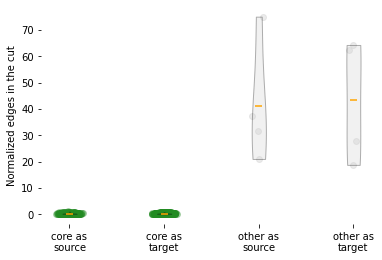

In [110]:
# Flow analysis
print("... Flow Analysis")

if len(core_indexes)>1 and len(other_indexes)>1:
    # The amount of flow on an edge cannot exceed the capacity of the edge.
    # therefore, edges with high capacity will be more important for the flow.
    # here we test the hypothesis that edges towards cores have higher capacity
    # or that the sum of edges towards cores have a higher total capacity
    cell_total_capacity = {cid:list() for cid in ophys_cell_ids}
    edges_sourcing = {cid:0 for cid in ophys_cell_ids}
    edges_targeting = {cid:0 for cid in ophys_cell_ids}

    for cluster_k,events_cellids in scan_clustered_spectrums.items(): # we consider only the scan 0 because it's the largest (for now)
        cluster_k = cluster_k.split(',')[0]

        if cluster_k == 'gray':
            continue

        for vnt in events_cellids:
            for posi,vidj in enumerate(vnt[1:]):
                vidi = vnt[posi] # enumerate will go from 0
                # print(vidi, vidj)

                # check beginning and end are not the same
                if dgraph.vs.find(ophys_cell_id=vidi).index == dgraph.vs.find(ophys_cell_id=vidj).index:
                    continue
                # # check there is a path between the two
                # if len(spinesgraph.get_all_shortest_paths(spinesgraph.vs.find(name=vidi).index, to=spinesgraph.vs.find(name=vidj).index, weights=None, mode='out'))>0:
                #     continue

                # Take the maximum flow between the previous and next vertices
                mfres = dgraph.maxflow(dgraph.vs.find(ophys_cell_id=vidi).index, dgraph.vs.find(ophys_cell_id=vidj).index)
                # print(mfres)
                # returns a tuple containing the following:
                # graph - the graph on which this flow is defined
                # value - the value (capacity) of the maximum flow between the given vertices
                # flow - the flow values on each edge. For directed graphs, this is simply a list where element i corresponds to the flow on edge i.
                # cut - edge IDs in the minimal cut corresponding to the flow.
                # partition - vertex IDs in the parts created after removing edges in the cut
                # es - an edge selector restricted to the edges in the cut.

                # we get a flow value for each edge contributing to the flow.
                # source
                mfres_value = mfres.value
                if vidi in np.array(ophys_cell_ids)[core_indexes]:
                    mfres_value /= len(core_indexes)
                else:
                    mfres_value /= len(other_indexes)
                cell_total_capacity[vidi].append(mfres_value)
                # target
                mfres_value = mfres.value
                if vidj in np.array(ophys_cell_ids)[core_indexes]:
                    mfres_value /= len(core_indexes)
                else:
                    mfres_value /= len(other_indexes)
                cell_total_capacity[vidj].append(mfres_value)

                # Iterate over the edges identified by the flow.
                # count the edges sourcing from cores, and those targeting cores. Which is more?
                for edge in mfres.es:
                    sourceid = int(dgraph.vs[edge.source]['ophys_cell_id'])
                    targetid = int(dgraph.vs[edge.target]['ophys_cell_id'])
                    if sourceid in cell_total_capacity.keys():
                        edges_sourcing[sourceid] +=1 # just count
                    if targetid in cell_total_capacity.keys():
                        edges_targeting[targetid] +=1 # just count

    # # Flow
    # # print(cell_total_capacity)
    # flowvalue_cores = []
    # for cid in np.array(ophys_cell_ids)[core_indexes]:
    #     flowvalue_cores.extend(cell_total_capacity[cid])
    # flowvalue_others = []
    # for cid in np.array(ophys_cell_ids)[other_indexes]:
    #     flowvalue_others.extend(cell_total_capacity[cid])
    # # description
    # print("    Flow cores: "+str(stats.describe(flowvalue_cores)) )
    # print("    Flow others: "+str(stats.describe(flowvalue_others)) )
    # # significativity
    # print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowvalue_cores, flowvalue_others, equal_var=False))
    # d,_ = stats.ks_2samp(flowvalue_cores, flowvalue_others) # non-parametric measure of effect size [0,1]
    # print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)
    # fig, ax = plt.subplots()
    # xs = np.random.normal(1, 0.04, len(flowvalue_cores))
    # plt.scatter(xs, flowvalue_cores, alpha=0.3, c='forestgreen')
    # xs = np.random.normal(2, 0.04, len(flowvalue_others))
    # plt.scatter(xs, flowvalue_others, alpha=0.3, c='silver')
    # vp = ax.violinplot([flowvalue_cores,flowvalue_others], widths=0.15, showextrema=False, showmeans=True)
    # for pc in vp['bodies']:
    #     pc.set_edgecolor('black')
    # for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
    #     pc.set_facecolor(cb)
    # vp['cmeans'].set_color('orange')
    # # vp['cmedians'].set_linewidth(2.)
    # ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # plt.ylabel('Normalized flow value')
    # plt.xticks([1, 2], ["core\n(n={:d})".format(len(flowvalue_cores)), "other\n(n={:d})".format(len(flowvalue_others))])
    # fig.savefig(exp_path+"/results/global_cores_others_flowvalue_%s.svg"%(scan_id), transparent=True)
    # plt.show()
    # # fig.clf()
    # # plt.close()

    # Cuts
    # print(edges_sourcing)
    # print(edges_targeting)
    flowcuts_core_sources = []
    flowcuts_core_targets = []
    for cid in np.array(ophys_cell_ids)[core_indexes]:
        flowcuts_core_sources.append(edges_sourcing[cid]/len(core_indexes))
        flowcuts_core_targets.append(edges_targeting[cid]/len(core_indexes))
    flowcuts_other_sources = []
    flowcuts_other_targets = []
    for cid in np.array(ophys_cell_ids)[other_indexes]:
        flowcuts_other_sources.append(edges_sourcing[cid]/len(other_indexes))
        flowcuts_other_targets.append(edges_targeting[cid]/len(other_indexes))

    # description
    print("    Cut edges sourcing from cores: "+str(stats.describe(flowcuts_core_sources)) )
    print("    Cut edges targeting cores: "+str(stats.describe(flowcuts_core_targets)) )
    print("    Cut edges sourcing from others: "+str(stats.describe(flowcuts_other_sources)) )
    print("    Cut edges targeting others: "+str(stats.describe(flowcuts_other_targets)) )
    # significativity
    print("    Core targets vs sources Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_core_sources, equal_var=False))
    d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_core_sources) # non-parametric measure of effect size [0,1]
    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

    print("    Core targets vs Other targets Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_other_targets, equal_var=False))
    d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_other_targets) # non-parametric measure of effect size [0,1]
    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

    fig, ax = plt.subplots()
    xs = np.random.normal(1, 0.04, len(flowcuts_core_sources))
    plt.scatter(xs, flowcuts_core_sources, alpha=0.3, c='forestgreen')
    xs = np.random.normal(2, 0.04, len(flowcuts_core_targets))
    plt.scatter(xs, flowcuts_core_targets, alpha=0.3, c='forestgreen')
    xs = np.random.normal(3, 0.04, len(flowcuts_other_sources))
    plt.scatter(xs, flowcuts_other_sources, alpha=0.3, c='silver')
    xs = np.random.normal(4, 0.04, len(flowcuts_other_targets))
    plt.scatter(xs, flowcuts_other_targets, alpha=0.3, c='silver')
    vp = ax.violinplot([flowcuts_core_sources,flowcuts_core_targets,flowcuts_other_sources,flowcuts_other_targets], widths=0.15, showextrema=False, showmeans=True)
    for pc in vp['bodies']:
        pc.set_edgecolor('black')
    for pc in vp['bodies'][0:2]:
        pc.set_facecolor('#228B224d')
    for pc in vp['bodies'][2:]:
        pc.set_facecolor('#D3D3D34d')
    vp['cmeans'].set_color('orange')
    # vp['cmedians'].set_linewidth(2.)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel('Normalized edges in the cut')
    plt.xticks([1, 2, 3, 4], ["core as\nsource", "core as\ntarget", "other as\nsource", "other as\ntarget"])
    fig.savefig(exp_path+"/results/global_cores_others_cutvalue_%s.svg"%(scan_id), transparent=True)
    # plt.show()
    # fig.clf()
    # plt.close()

### PageRank

If a network has high flow nodes, they will also score high in the [PageRank algorithm](https://en.wikipedia.org/wiki/PageRank).    
Core neurons having both high flow values and high cut values should have a higher pagerank value than others.

... PageRank centrality
    cores: DescribeResult(nobs=1996, minmax=(0.00011973598291181972, 0.0011581248102254138), mean=0.0005001669739432413, variance=2.3763328257558504e-08, skewness=0.34568566634149756, kurtosis=0.19850525117012108)
    others: DescribeResult(nobs=4, minmax=(0.00022131414915937215, 0.000689111530745921), mean=0.0004166800023225701, variance=3.855548400836063e-08, skewness=0.6412449546574901, kurtosis=-0.9153614523529172)
    Kruskal-Wallis test:  1.289 p= 0.256
    Kolmogorov-Smirnov Effect Size: 0.500


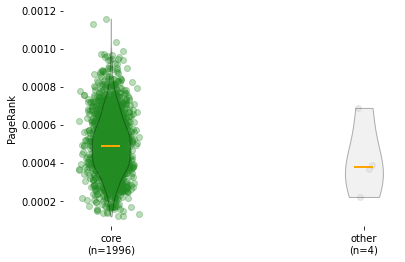

In [111]:
print('... PageRank centrality')
pagerank_cores = []
pagerank_others = []

if len(core_indexes)>1:
    pagerank_cores = np.array(dgraph.personalized_pagerank(vertices=core_indexes, directed=True, damping=0.85, reset="is_core"))
if len(other_indexes)>1:
    pagerank_others = np.array(dgraph.personalized_pagerank(vertices=other_indexes, directed=True, damping=0.85, reset="is_core"))
    
if len(core_indexes)>1 and len(other_indexes)>1:
    
    # description
    print("    cores: "+str(stats.describe(pagerank_cores)) )
    print("    others: "+str(stats.describe(pagerank_others)) )
    # significativity
    print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.kruskal(pagerank_cores, pagerank_others))
    d,_ = stats.ks_2samp(pagerank_cores, pagerank_others) # non-parametric measure of effect size [0,1]
    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

    fig, ax = plt.subplots()
    xs = np.random.normal(1, 0.04, len(pagerank_cores))
    plt.scatter(xs, pagerank_cores, alpha=0.3, c='forestgreen')
    xs = np.random.normal(2, 0.04, len(pagerank_others))
    plt.scatter(xs, pagerank_others, alpha=0.3, c='silver')
    vp = ax.violinplot([pagerank_cores,pagerank_others], widths=0.15, showextrema=False, showmedians=True)
    for pc in vp['bodies']:
        pc.set_edgecolor('black')
    for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
        pc.set_facecolor(cb)
    vp['cmedians'].set_color('orange')
    vp['cmedians'].set_linewidth(2.)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylabel('PageRank')
    plt.xticks([1, 2], ["core\n(n={:d})".format(len(pagerank_cores)), "other\n(n={:d})".format(len(pagerank_others))])
    fig.savefig(exp_path+"/results/global_cores_others_pagerank_%s.svg"%(scan_id), transparent=True)
    plt.show()
